# Transfomer for time series data

## Objectives of this Lab

- Develop an understanding of the fundamental concepts behind Transformers and implement a basic version.
- Gain an introductory understanding of applications of deep learning in finance.
- Assess and reinforce your existing knowledge of deep learning.
- Explore the potential to apply these skills effectively—on the journey to becoming an expert (and maybe... wealthy). 🚀


In this lab, we aim to build a model capable of predicting trends in stock values, laying the groundwork for a potential trading bot. To achieve this, we will leverage the Transformer Encoder, which is well-suited for capturing complex temporal dependencies in financial data.


In [1]:
!pip install pytorch-lightning
!pip install wandb
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
# Standard Libraries
import os
import copy
import math
import random
from typing import Optional, List

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST

# PyTorch Lightning 
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

# Scientific Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import matplotlib.pyplot as plt

# Computer Vision
import cv2
import cv2 as cv

# Wandb and Financial Data
import wandb
import yfinance as yf

# Constants
USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

if not wandb.login():
    raise ValueError("WandDB authentification failed.")

seed_everything(42)


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: salaheddinerizki11 (salaheddinerizki11-ensea) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
INFO:lightning_fabric.utilities.seed:Seed set to 42


# Transformer

## Before Transformers: Sequence Modeling Challenges

Before the advent of Transformers, sequence modeling tasks primarily relied on recurrent neural network (RNN) architectures, such as vanilla RNNs, LSTMs (Long Short-Term Memory networks), and GRUs (Gated Recurrent Units). These architectures were designed to process data sequentially, making them well-suited for tasks where temporal or sequential relationships are critical, such as language modeling, translation, and time-series analysis.

**Strengths of RNNs, LSTMs, and GRUs:**
- Sequential Processing: RNNs inherently model temporal dependencies by processing input data token by token.
- Memory Mechanisms: LSTMs and GRUs improve on standard RNNs by incorporating gating mechanisms to capture long-range dependencies and mitigate the vanishing gradient problem.

**Key Challenges and Limitations:**
- Sequential Computation: The sequential nature of RNNs makes training and inference slow, as tokens must be processed in order. This limits parallelization and scalability.
- Long-Term Dependencies: Despite improvements, capturing very long-range dependencies remains challenging. Models often fail to effectively propagate information over extended sequences.
- Gradient Issues: RNNs can suffer from vanishing or exploding gradients, making it difficult to train deep models on long sequences.
Fixed-Length Representations: Many traditional architectures compress variable-length sequences into fixed-size vectors, potentially losing important information.


## The Need for a Paradigm Shift:

The limitations of RNN-based architectures inspired the search for alternatives capable of:
- Parallelizing computation for faster training and inference.
- Handling long-range dependencies efficiently.
- Representing sequences in a more flexible and scalable manner.

This led to the development of Transformers, which utilize self-attention mechanisms to address these challenges, transforming how sequence modeling is approached.

## Attention: The Core of Transformers

Attention, self-attention, and multi-head attention are central to the Transformer architecture. These mechanisms enable the model to focus on the most relevant parts of the input, dynamically identifying important regions or tokens for a given task.
- Self-Attention: Computes relationships between all tokens in the input, capturing both local and global dependencies effectively.
- Multi-Head Attention: Extends self-attention by processing multiple subspaces simultaneously, allowing the model to focus on diverse aspects of the input (e.g., syntax, semantics).

Advantages of Attention:
- Processes tokens in parallel, enabling faster computation.
- Captures long-range dependencies across the input.
- Improves representational flexibility for complex relationships.
Attention mechanisms form the backbone of the Transformer's ability to model sequences efficiently and effectively.

## Architecture Overview

The Transformer is a neural network architecture fundamentally built on attention mechanisms. It is structured as an **encoder-decoder** framework, with distinct roles for each component:
- **Encoder:** Maps an input sequence of symbol representations $(x_1, \dots, x_n)$ to a sequence of intermediate representations $(z_1, \dots, z_n)$.  
- **Decoder:** Takes the encoder's output $z$ and generates an output sequence $(y_1, \dots, y_m)$.  

A key characteristic of the decoder is that it operates in an **auto-regressive** manner: at each time step, it uses the previously generated symbols as additional inputs to generate the next symbol in the sequence. This property ensures that the output is generated sequentially, preserving dependencies between tokens.

<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width= 400>    
<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width= 400>

# Positional Encoding

Transformers operate on sequences of data where the order of elements is critical. To illustrate the importance of order, consider the following example:

> Vivre pour manger ≠ Manger pour vivre.

In recurrent architectures such as RNNs, LSTMs, or GRUs, the sequential nature of processing inherently captures positional information, as tokens are processed in order. However, Transformers lack this sequential mechanism due to their parallelized processing of input sequences. This raises an important question:

How can we encode the positional information of tokens within the Transformer architecture?

The solution proposed by the authors of the Transformer model involves incorporating positional information directly into the input embeddings. This is achieved by adding a positional encoding vector to each token's embedding. These positional encodings effectively convey the position of each token within the sequence, enabling the model to understand the relative and absolute order of tokens.

Formally, the positional encoding for a token at position $pos$ and dimension $i$ is defined as:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

where:
- $pos$ is the position of the token in the sequence.
- $i$ refers to the dimension of the positional encoding.
- $d_{\text{model}}$ is the dimensionality of the model (embedding dimension).

The wavelength form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$ across the dimensions. This function allows the model to learn representations that consider both the absolute and relative positions of tokens in the sequence.


# 1 - Data

## 1.1 Data Collection

You are encouraged to download and analyze any stock data of your choice, making the learning experience both practical and customizable.
You need table of stock data with the following columns:
- Date
- Open
- High
- Low
- Close
- Volume
- Adj Close

You can obtain stock data in several ways:
- download the data from any source that provide a "csv"-like file
    * S&P500 : https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC,  https://www.nasdaq.com/market-activity/index/spx/historical
    * Bitcoin : https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD,...
    * Gold : https://finance.yahoo.com/quote/GC%3DF/history?p=GC%3DF,..
- use the `yfinance` library to download the data directly from the Yahoo Finance website
    - S&P500: "^GSPC"
    - Bitcoin: "BTC-USD"
    - Gold: "GC=F"

Note: A longer historical period is essential to capture trends and train the model effectively.

In [3]:
import yfinance as yf
import pandas as pd

# option 2
data_dict = {"S&P500":"^GSPC","Bitcoin":"BTC-USD", 'Gold':"GC=F"}
for key,value in data_dict.items():
    data_dict[key]= yf.Ticker(value).history(start="2018-01-01", end="2025-02-23")


## 1.2 - EDA: Identifying Trends in Your Stock  

As a Data Scientist, the first step is to thoroughly explore the data before proceeding with modeling. This step, known as **Exploratory Data Analysis (EDA)**, is essential for understanding the data and preparing it for subsequent tasks.  

<img src="https://miro.medium.com/v2/resize:fit:862/1*bNSd-pm4XjkOV7uSTNAfnA.jpeg" width= 400>


**Time Series** data consists of data points indexed by time, typically organized as sequences of equally spaced intervals. In this exercise, we will explore a stock dataset to gain insights into its behavior over time.  


**Goals of EDA**:  
- Provide a **description of the stock** and its context.  
- Summarize the dataset's features and their distributions.  
- Hypothesize **potential trends for the next week** based on observed patterns.  
- Visualize **key features** and their temporal behavior.  
- Examine the **correlations** between features to uncover relationships.

To achieve these goals, you can use various Python libraries for data manipulation and visualization:
- [**`pandas`**](https://pandas.pydata.org/docs/index.html): For reading CSV files and data manipulation.  
  - `read_csv()`: Reads the CSV file.  
  - `head()`: Displays the first rows of the dataset.  
  - `describe()`: Summarizes statistics for numerical features.
- [**`seaborn`** ](https://seaborn.pydata.org/): For creating attractive and informative visualizations.  
  - `displot()`: Visualizes feature distributions.  
  - `heatmap()`: Displays correlations between features.
- [**`matplotlib`**](https://matplotlib.org/): For basic plotting and visual analysis.  

---

**1. Perform Feature Summarization:**  
- Summarize key metrics such as `Open`, `Close`, `High`, `Low`, and `Volume` using `describe()`.  
- Identify missing values, outliers, or unusual distributions.  

**2. Visualize Key Features:**  
- Use **`matplotlib`** or **`seaborn`** to plot trends in stock prices (`Close`, `Open`) over time.  
- Explore the distribution of features using `displot()`.  

**3. Analyze Feature Correlations:**  
- Compute correlations between numerical features (e.g., between `Volume` and `Close`).  
- Visualize the correlation matrix using a heatmap.  

**4. Hypothesize Trends:**  
- Based on patterns in the data, make an educated guess about potential trends for the next week.

**5. Formulate Hypotheses:**  
- Use observations from the visualizations and summary statistics to hypothesize potential trends in the stock for the upcoming week. For instance, identify patterns such as steady growth, volatility, or mean-reversion tendencies.



In [4]:
# TODO: a in depth EDA
# 1 - Feature Summarization
for key,value in data_dict.items():
    data_dict[key]=pd.DataFrame(value)
    print("Description of the Dataset", key,"\n", data_dict[key].describe(),"\n")
for key,value in data_dict.items():
    print("Missing values in the Dataset", key,"\n", data_dict[key].isna().sum(),"\n")

Description of the Dataset S&P500 
               Open         High          Low        Close        Volume  \
count  1795.000000  1795.000000  1795.000000  1795.000000  1.795000e+03   
mean   3891.738565  3913.569466  3868.291112  3892.292969  4.162900e+09   
std     956.767936   959.188162   954.378407   957.101980  1.002768e+09   
min    2290.709961  2300.729980  2191.860107  2237.399902  1.296530e+09   
25%    2942.239990  2954.494995  2925.080078  2942.395020  3.545185e+09   
50%    3919.929932  3955.310059  3901.270020  3924.260010  3.946360e+09   
75%    4474.375000  4493.755127  4450.294922  4472.955078  4.528415e+09   
max    6134.500000  6147.430176  6111.149902  6144.149902  9.976520e+09   

       Dividends  Stock Splits  
count     1795.0        1795.0  
mean         0.0           0.0  
std          0.0           0.0  
min          0.0           0.0  
25%          0.0           0.0  
50%          0.0           0.0  
75%          0.0           0.0  
max          0.0        

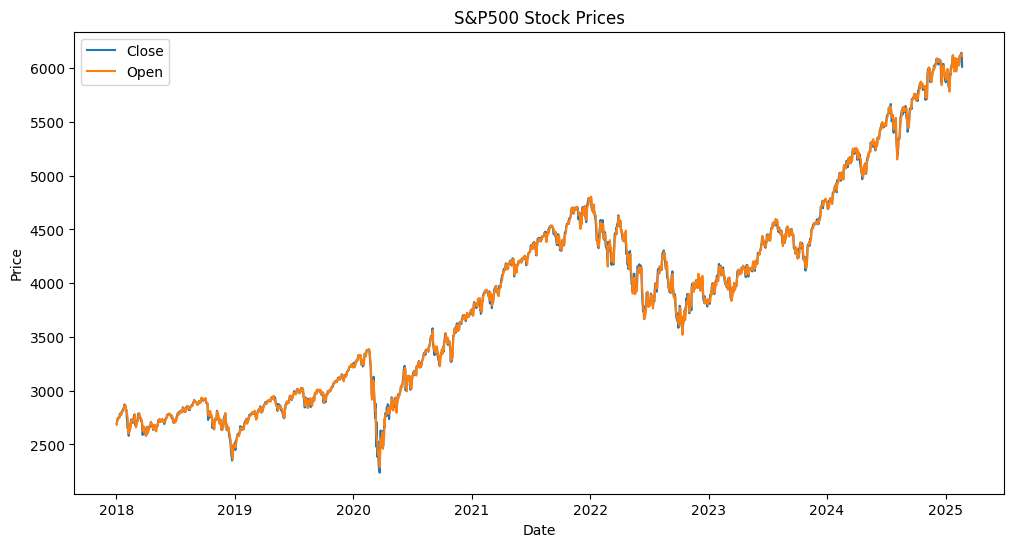

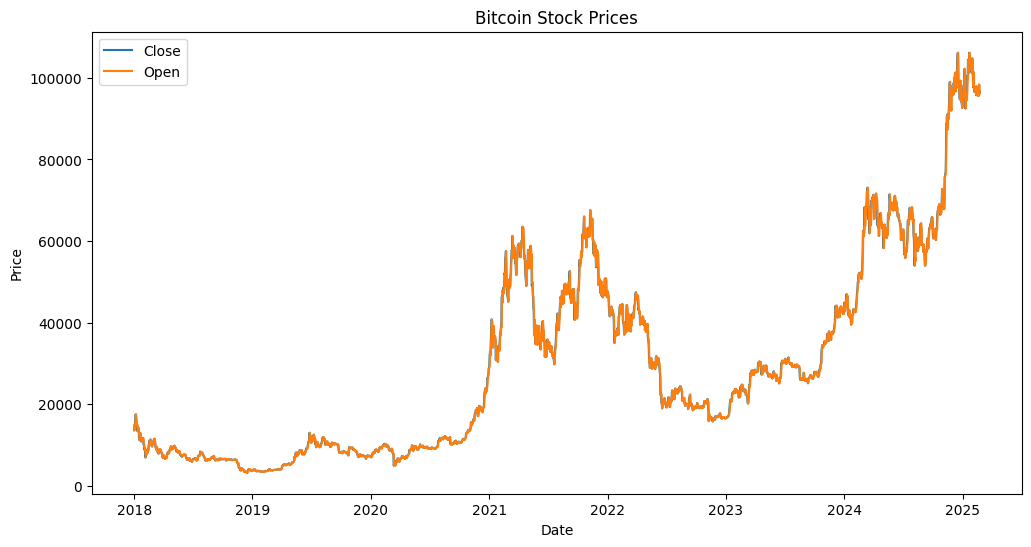

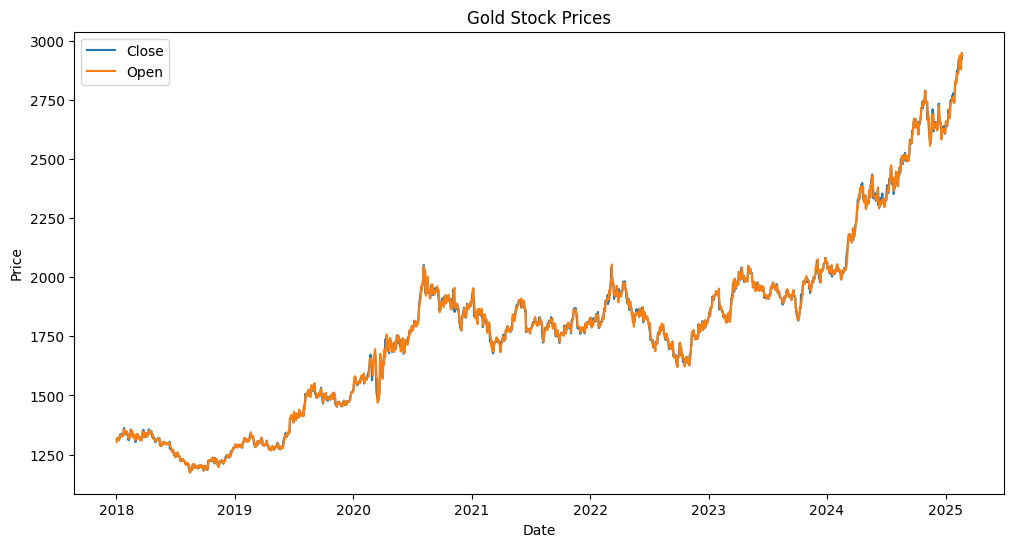

In [5]:
#2 - Visualize key features
import matplotlib.pyplot as plt
import seaborn as sns
for key,value in data_dict.items():
    plt.figure(figsize=(12, 6))
    plt.plot(data_dict[key].index, data_dict[key]['Close'], label='Close')
    plt.plot(data_dict[key].index, data_dict[key]['Open'], label='Open')
    plt.title(f'{key} Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


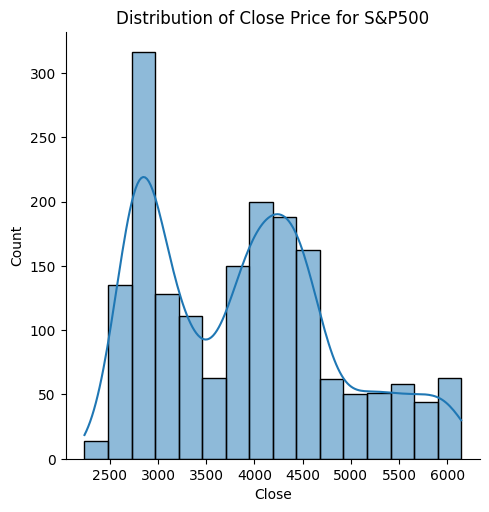

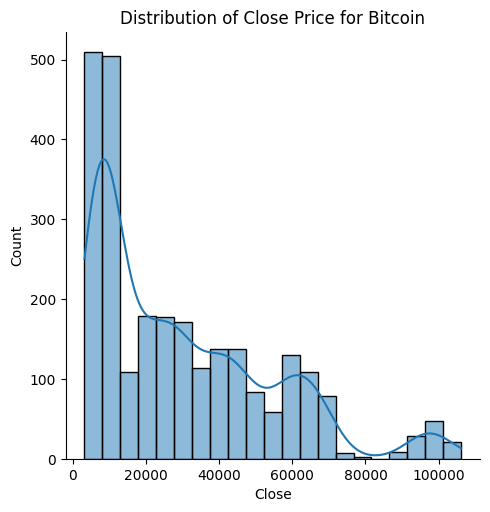

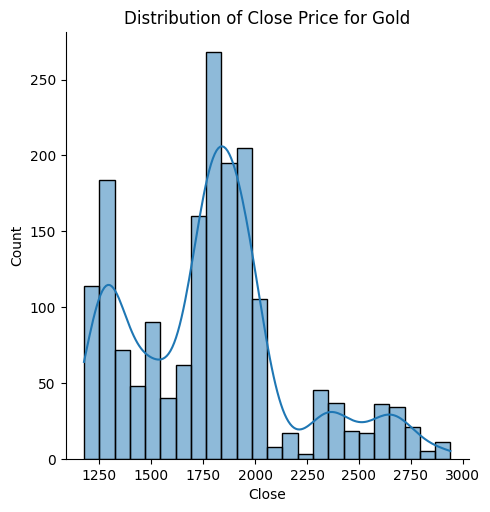

In [6]:
# Distribution of key features :
for key,value in data_dict.items():
    g = sns.displot(data=data_dict[key], x="Close", kde=True,)
    g.set(title=f'Distribution of Close Price for {key}')
    plt.show()

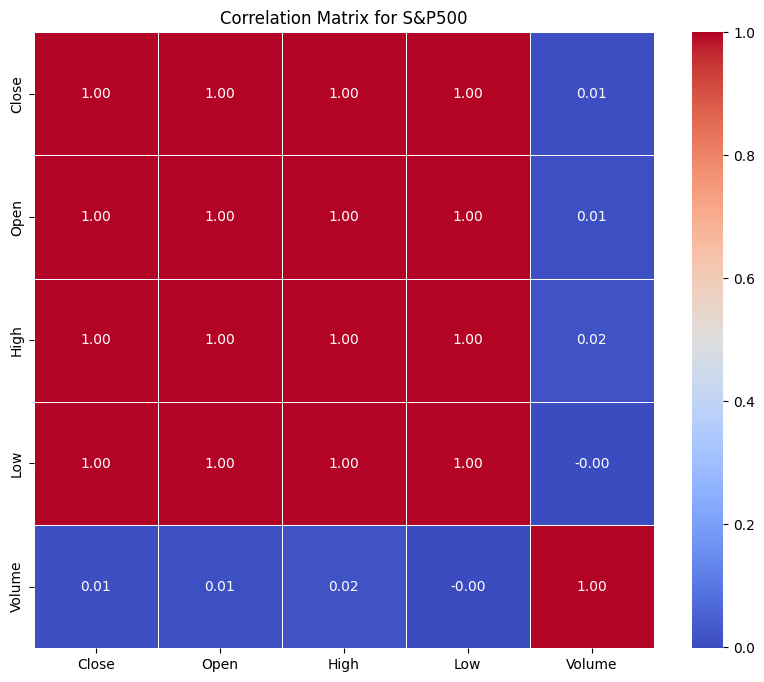

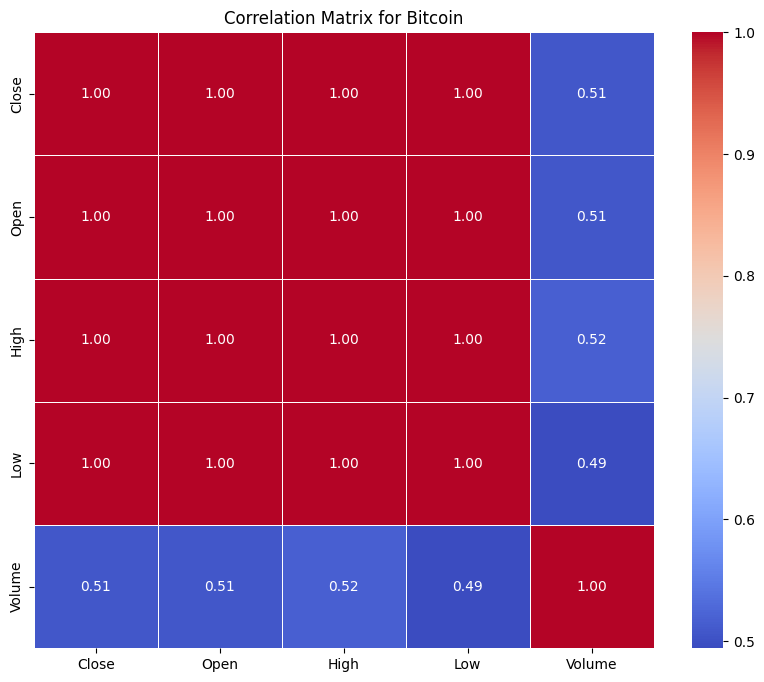

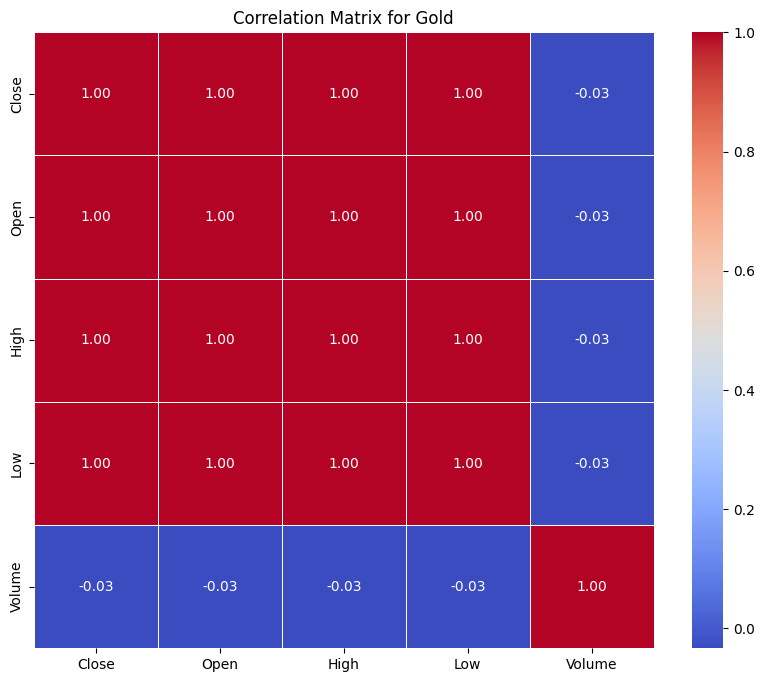

In [7]:
#3 - Analyze feature correlations
for key, value in data_dict.items():
    plt.figure(figsize=(10, 8))  # Adjust figure size
    numeric_df = value[["Close", "Open", "High", "Low","Volume"]] # Select only numeric columns
    corr_matrix = numeric_df.corr()  # Compute correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Correlation Matrix for {key}')
    plt.show()

# **Identifying Steady Growth, Volatility and Mean reversion tendencies**

*1 - Steady Growth*

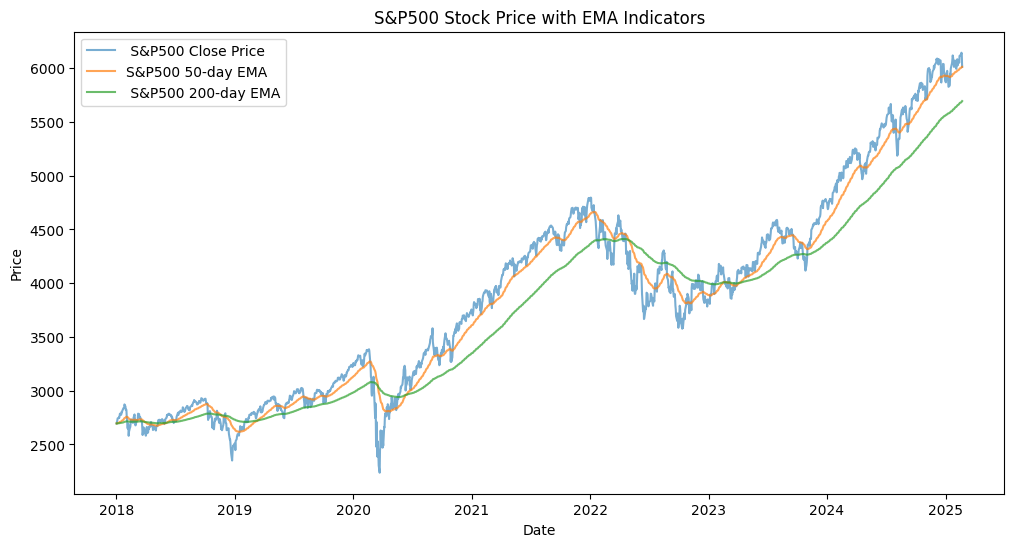

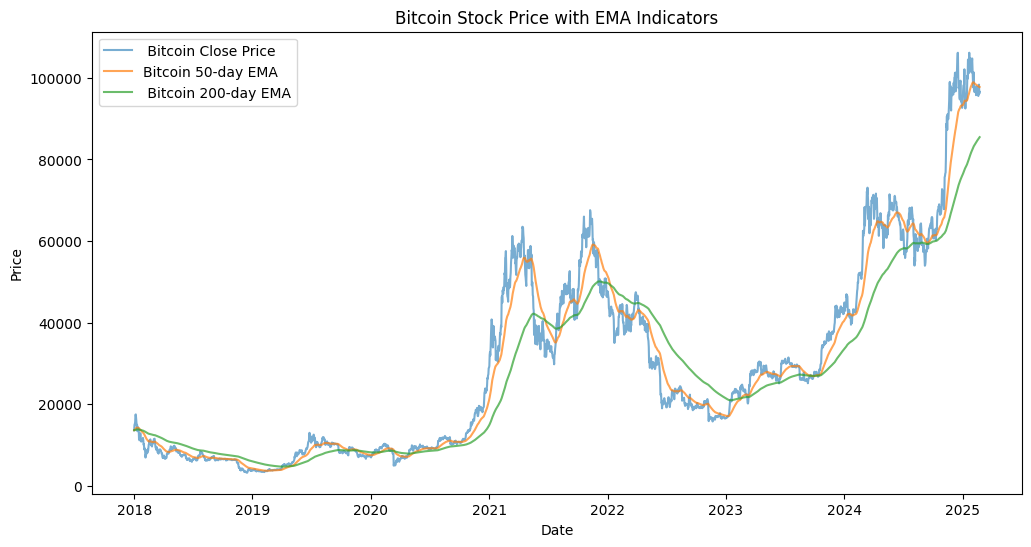

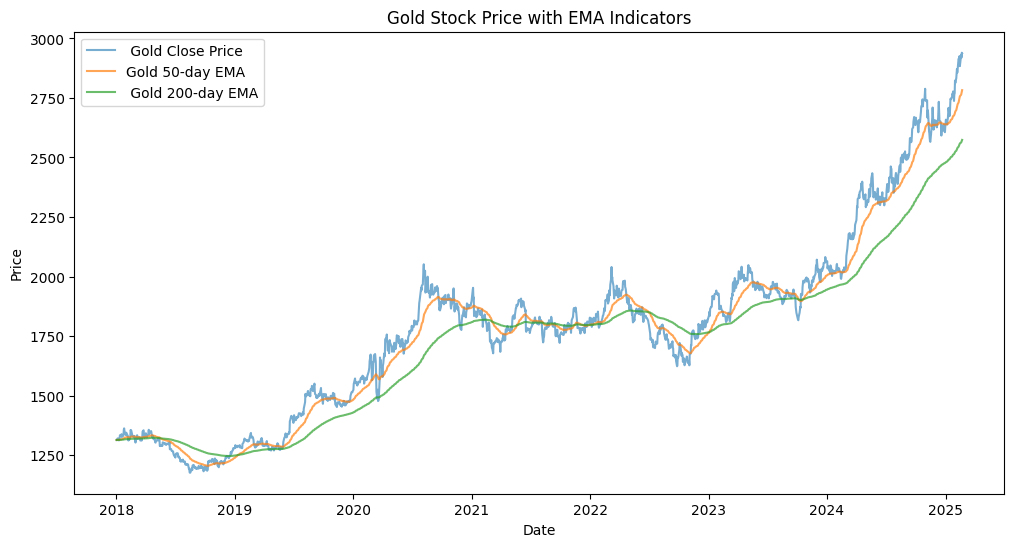

In [8]:
#Computing 50-day and 200-day EMA
for key, value in data_dict.items():
  value["Date"]=pd.to_datetime(value.index)
  value.set_index("Date", inplace=True)
  value["EMA_50"] = value["Close"].ewm(span=50, adjust=False).mean()
  value["EMA_200"] = value["Close"].ewm(span=200, adjust=False).mean()

  # Plot the EMA indicators
  plt.figure(figsize=(12, 6))
  plt.plot(value.index, value["Close"], label=f" {key} Close Price", alpha=0.6)
  plt.plot(value.index, value["EMA_50"], label=f"{key} 50-day EMA", alpha=0.7)
  plt.plot(value.index, value["EMA_200"], label=f" {key} 200-day EMA", alpha=0.7)
  plt.legend()
  plt.title(f"{key} Stock Price with EMA Indicators")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.show()




**Conclusions :** *We can see that the 50-day EMA curve is above the 200-day EMA curve from the end of 2023 for all our datasets, which indicates a long-term uptrend (Steady growth)*

*2 - Volatility*


Now we will try to detect Volatility using Rolling Standard Deviation and Bollinger Bands :

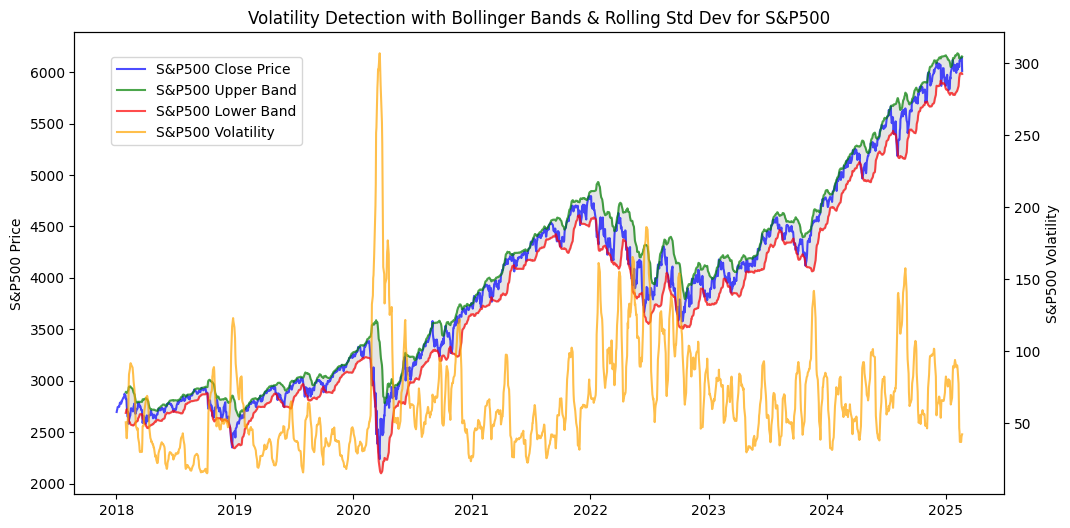

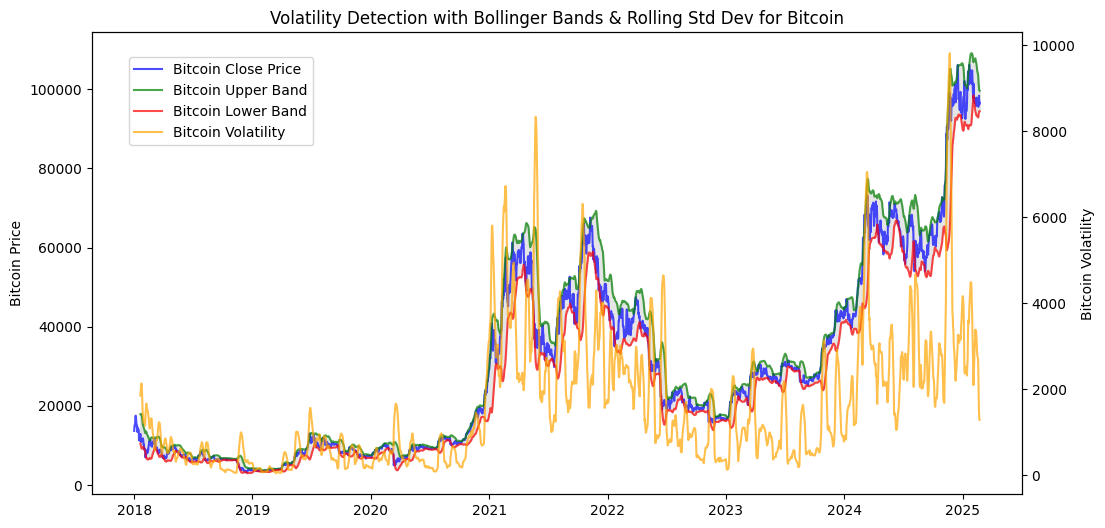

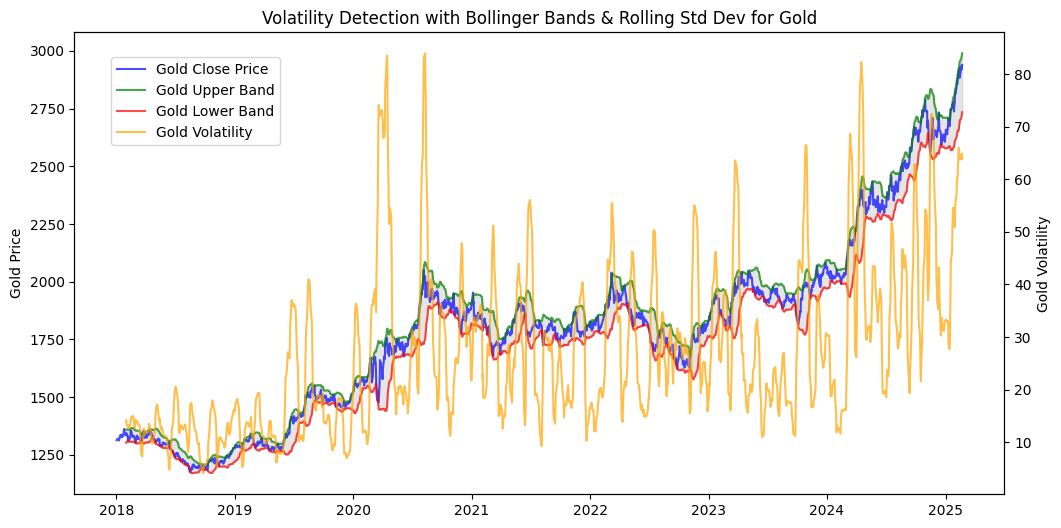

In [9]:
for key, value in data_dict.items():
  value["Date"]=pd.to_datetime(value.index)
  value.set_index("Date", inplace=True)

  # Compute Rolling Standard Deviation (Volatility) over a 20-day window
  value["Volatility"] = value["Close"].rolling(window=20).std()

  # Compute Bollinger Bands (20-day SMA ± 2 Standard Deviations)
  value["SMA_20"] = value["Close"].rolling(window=20).mean()
  value["Upper_Band"] = value["SMA_20"] + 2 * value["Volatility"]
  value["Lower_Band"] = value["SMA_20"] - 2 * value["Volatility"]

  # Plot Price, Bollinger Bands, and Volatility

  # Price and Bollinger Bands
  fig, ax1 = plt.subplots(figsize=(12, 6))
  ax1.plot(value.index, value["Close"], label=f"{key} Close Price", color="blue", alpha=0.7)
  ax1.plot(value.index, value["Upper_Band"], label=f"{key} Upper Band", color="green", alpha=0.7)
  ax1.plot(value.index, value["Lower_Band"], label=f"{key} Lower Band", color="red", alpha=0.7)
  ax1.fill_between(value.index, value["Upper_Band"], value["Lower_Band"], color="gray", alpha=0.2)
  ax1.set_ylabel(f"{key} Price")
  ax1.set_title(f"Volatility Detection with Bollinger Bands & Rolling Std Dev for {key}")

  # Volatility (Rolling Std Dev) on secondary axis
  ax2 = ax1.twinx()
  ax2.plot(value.index, value["Volatility"], label=f"{key} Volatility", color="orange", alpha=0.7)
  ax2.set_ylabel(f"{key} Volatility")

  fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
  plt.show()


**Interpretation :** *We can see that when we have wider bands tha volatility increases (Last quarter of 2020 for gold anf first quarter of 2020 for S&P500 for example). The Bollinger Bands could be a good indicator for trading operations as when the price curve touches the upper band this could mean a potential sell signal ; on the contrary when it touches the lower band this means that we're in Oversold conditions which could be a potential buy signal.*

*3 - Mean reversion tendencies :*

We will use ADF(Augmented Dickey-Fuller) Test to determine the stationarity of our timeseries and the Z-Score of price which measures how far the price deviates from its moving average (mean-reversion signal).


📊 Analyzing Mean Reversion for: S&P500

ADF Test Statistic: 0.157
P-Value: 0.970
Critical Values: {'1%': np.float64(-3.4340208151070124), '5%': np.float64(-2.8631614607057587), '10%': np.float64(-2.5676332144347365)}
❌ The time series is NON-STATIONARY → No strong mean reversion.


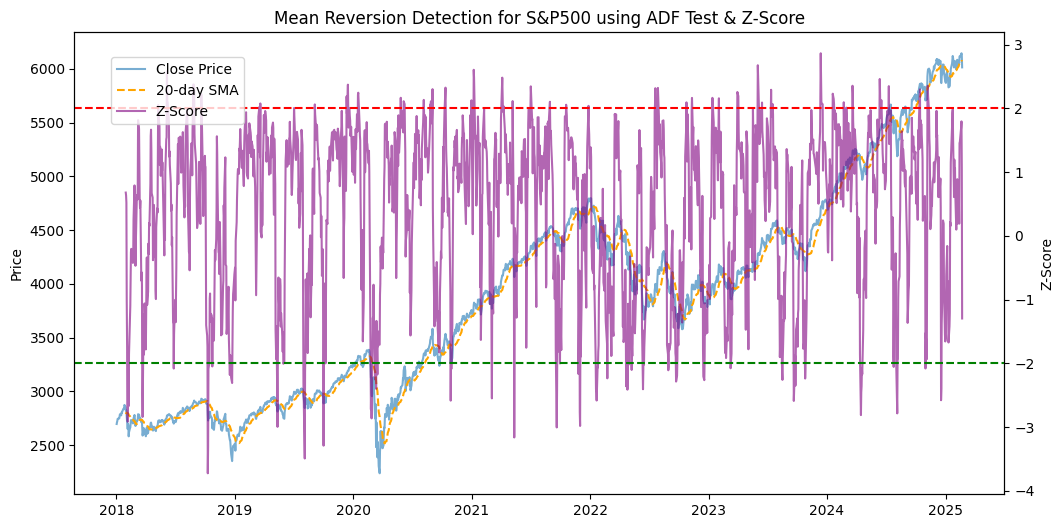


📊 Analyzing Mean Reversion for: Bitcoin

ADF Test Statistic: -0.300
P-Value: 0.925
Critical Values: {'1%': np.float64(-3.432886154825581), '5%': np.float64(-2.862660475187928), '10%': np.float64(-2.5673664697163323)}
❌ The time series is NON-STATIONARY → No strong mean reversion.


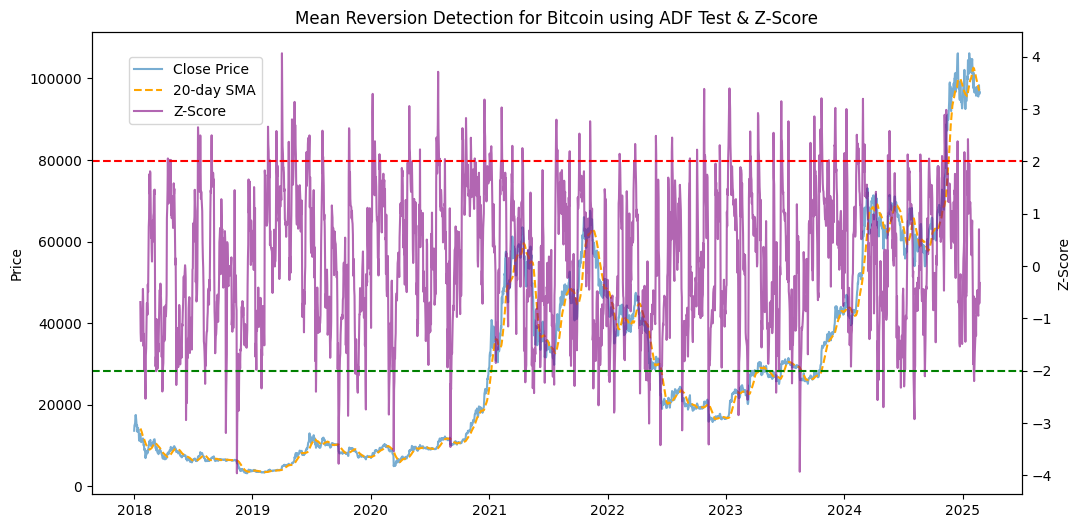


📊 Analyzing Mean Reversion for: Gold

ADF Test Statistic: 1.097
P-Value: 0.995
Critical Values: {'1%': np.float64(-3.434002362895342), '5%': np.float64(-2.863153315036348), '10%': np.float64(-2.5676288771043367)}
❌ The time series is NON-STATIONARY → No strong mean reversion.


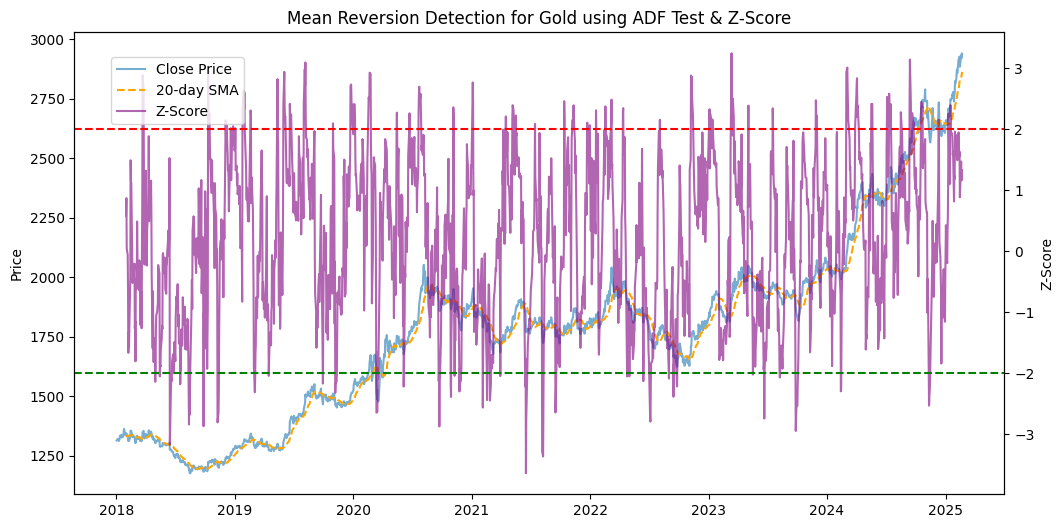

In [10]:
from statsmodels.tsa.stattools import adfuller

for key, value in data_dict.items():
    print(f"\n📊 Analyzing Mean Reversion for: {key}\n")

    # Ensure 'Date' is a datetime index
    value["Date"]=pd.to_datetime(value.index)
    value.set_index("Date", inplace=True)

    # Compute 20-day Simple Moving Average (SMA)
    value["SMA_20"] = value["Close"].rolling(window=20).mean()

    # Compute Rolling Standard Deviation (20-day)
    value["Volatility"] = value["Close"].rolling(window=20).std()

    # Compute Z-Score: (Price - Mean) / Standard Deviation
    value["Z-Score"] = (value["Close"] - value["SMA_20"]) / value["Volatility"]

    # Run ADF Test
    adf_result = adfuller(value["Close"].dropna())

    # Print ADF Test results
    print(f"ADF Test Statistic: {adf_result[0]:.3f}")
    print(f"P-Value: {adf_result[1]:.3f}")
    print("Critical Values:", adf_result[4])

    if adf_result[1] < 0.05:
        print("✅ The time series is STATIONARY → Likely MEAN-REVERTING.")
    else:
        print("❌ The time series is NON-STATIONARY → No strong mean reversion.")

    # Plot Close Price & Z-Score
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Price and SMA
    ax1.plot(value.index, value["Close"], label="Close Price", alpha=0.6)
    ax1.plot(value.index, value["SMA_20"], label="20-day SMA", linestyle="dashed", color="orange")
    ax1.set_ylabel("Price")
    ax1.set_title(f"Mean Reversion Detection for {key} using ADF Test & Z-Score")

    # Plot Z-Score on Secondary Axis
    ax2 = ax1.twinx()
    ax2.plot(value.index, value["Z-Score"], label="Z-Score", color="purple", alpha=0.6)
    ax2.axhline(2, linestyle="dashed", color="red")  # Overbought threshold
    ax2.axhline(-2, linestyle="dashed", color="green")  # Oversold threshold
    ax2.set_ylabel("Z-Score")

    fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
    plt.show()


*Additional info : (Trading signal)*



1.   Z-Score > 2 → Overbought → Price likely to revert downward (Short Opportunity 🚨)
2.   Z-Score < -2 → Oversold → Price likely to revert upward (Buy Opportunity ✅)

## 1.3 - Creating a Stock Dataset


### Features
In this section, we will process a stock dataset containing multiple features. We will focus on utilizing the **attention mechanism** to process five specific features:

- **Open**
- **High**
- **Low**
- **Close**
- **Volume**

### Sliding Window Approach

We will use a *sliding, non-overlapping* window of size $N_{window}$ to generate input-output pairs. The input for each sequence will consist of the previous $N_{window}$ time steps, and the output will be the following $N_{window}$ time steps. Specifically, we aim to approximate the following relationship:

$$
f(W_t) \approx W_{t+1}
$$

Where:

$$
W_t = (p_{t_{w}}, p_{t_{w+1}}, \dots, p_{t_{w+N_{window}-1}})
$$

Example for $N_{window} = 3$

- **Input 1**: $[p_0, p_1, p_2]$  
  **Label 1**: $[p_3, p_4, p_5]$

- **Input 2**: $[p_3, p_4, p_5]$  
  **Label 2**: $[p_6, p_7, p_8]$

- **Input 3**: $[p_6, p_7, p_8]$  
  **Label 3**: $[p_9, p_{10}, p_{11}]$


### Dataset class

We will construct a dataset compatible with PyTorch's `Dataset` class. The custom dataset will take the following inputs:
- **Dataframe(s)** containing the stock data.
- **$N_{window}$**: The length of the sequence, representing the window size.
- normalized: A boolean indicating whether to normalize the data (Min-Max scaling to [-1, 1]).
- num_steps: The number of steps between consecutive data points. This parameter allows for the creation of sequences with a gap between each data point, enabling the model to learn from more diverse patterns.

Since we are dealing with time series data, which is inherently sequential, each data point $p_{i}$ belongs to a sequence of length $N_{window}$. The goal is to predict the future behavior of the stock based on past observations.

The `__getitem__` method should return a dictionary containing the following:
- **`dict['input']`**: A list of $N_{window}$ input values.
- **`dict['label']`**: A list of $N_{window}$ target values (the future values the model needs to predict).  



In [11]:
for key, value in data_dict.items():
    data_dict[key]=data_dict[key][["Open","High","Low","Close","Volume","Dividends","Stock Splits"]]


In [12]:
for key, value in data_dict.items():
  print(data_dict[key].columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [13]:
class StockDataset(Dataset):
    def __init__(self, df, N_window, normalized=True, num_steps=1):
        self.df = df
        self.df.dropna(how="any", axis=0, inplace=True)
        self.N_window = N_window
        self.num_steps = num_steps
        self.normalized = normalized
        self.X, self.y = self.process_df()

    def process_df(self):
        """
        process method should return X,y:
        * X is an array of num_steps*N_windows input values
        * y is an array of corresponding target values
        """
        scaler = MinMaxScaler(feature_range=(-1, 1))
        data_raw = self.df.to_numpy()
        close = self.df["Close"].to_numpy()
        open = self.df["Open"].to_numpy()
        high = self.df["High"].to_numpy()
        low = self.df["Low"].to_numpy()
        volume = self.df["Volume"].to_numpy()

        if self.normalized:
            close = scaler.fit_transform(close.reshape(-1, 1))
            open = scaler.fit_transform(open.reshape(-1, 1))
            high = scaler.fit_transform(high.reshape(-1, 1))
            low = scaler.fit_transform(low.reshape(-1, 1))
            volume = scaler.fit_transform(volume.reshape(-1, 1))
        assert len(close) == len(open) == len(high) == len(low) == len(volume)
        data_raw = np.hstack([close, open, high, low, volume])

        print(data_raw.shape)

        # TODO : Create a list of non-overlaping sequences of N_window elements
        windows = []
        for i in range(0, len(data_raw) - self.N_window - self.num_steps, self.N_window):
            window = data_raw[i:i + self.N_window]
            target = data_raw[i + self.num_steps : i + self.N_window + self.num_steps]
            windows.append((window, target))


        # TODO : Return an array of sequences where X is the input values and y the target values
        X = np.array([window for window, _ in windows])
        y = np.array([target for _, target in windows])
        return X, y

    def __len__(self):
        """
        Be careful on your len because of the overlapping issues
        """
        # TODO : What is the len of the dataset ?
        return len(self.X)

    def __getitem__(self, idx):
        """
        __getitem__ method should return a dictionnary where :
        * dict['input'] : is a list of num_{steps} lists of N_{window} elements
        * dict['label'] : is a list of N_{window} target value
        """
        # TODO : Return one element
        x = self.X[idx]
        y = self.y[idx]
        return {"input": x, "label": y}




In [14]:
for key, value in data_dict.items():
  df = data_dict[key]
  N_window = 7
  normalized = True
  dataset = StockDataset(df, N_window, normalized)


  assert dataset[0]["input"].shape == (N_window, 5)
  assert dataset[0]["label"].shape == (N_window, 5)

(1795, 5)
(2610, 5)
(1795, 5)


<ipython-input-13-022e5694a165>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(how="any", axis=0, inplace=True)


## 1.4 - Creating the Lightning DataModule

As usual create a Lightning Datamodule that encompasses everything.

In [15]:
class StockDataModule(pl.LightningDataModule):
    def __init__(self, df, N_window, normalized, batch_size):
        super().__init__()
        self.df = df
        self.N_window = N_window
        self.normalized = normalized
        self.batch_size = batch_size

    def setup(self, stage):
        # First stage is 'fit' (or None)

        # TODO : Do we shuffle the datasets ? Why ?
        X_train, X_test = train_test_split(self.df, shuffle=True)
        X_train, X_valid = train_test_split(X_train, shuffle=True)

        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            # TODO : As usual
            self.stock_train = StockDataset(X_train,self.N_window,self.normalized)
            self.stock_valid = StockDataset(X_valid,self.N_window,self.normalized)

        # Second stage is 'test'
        if stage == "test" or stage is None:
            # TODO : As usual
            self.stock_test = StockDataset(X_test,self.N_window,self.normalized)

    def train_dataloader(self):
        return DataLoader(self.stock_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.stock_valid, self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.stock_test, self.batch_size, shuffle=False)

In [16]:
# TODO : Initialize your datamodule
datamodules={}
for key, value in data_dict.items():
  df = data_dict[key]
  N_window = 7
  normalized = True
  batch_size = 32

  datamodules[key]=StockDataModule(df, N_window, normalized, batch_size)
  datamodules[key].setup(stage=None)

(1009, 5)
(337, 5)
(449, 5)
(1467, 5)
(490, 5)
(653, 5)
(1009, 5)
(337, 5)
(449, 5)


## 2 - Positional Encoding : Incorporating Time to the features with Time2Vector

As we have seen, transformers are not able to understand the order of the data.
Usually, the original mechanism to encode the position of the data is to use a positional encoding. However, this encoding doesn't provide any sense of time.

One proposed solution is to use a [Time2Vector](https://arxiv.org/abs/1907.05321) layer to encode the time information. The Time2Vector layer is a simple neural network layer that converts time into a vector representation. This vector representation can then be concatenated with the input features to provide the model with temporal information.

Time2Vector is a model-agnostic vector representation for time. The main idea of this vector is that :
* a meaningful representation of time has to include both periodic and non-periodic patterns.
* a time representation should have an invariance to time rescaling

$$ \texttt{t2v}(\tau)[i] =
  \begin{cases}
    \omega_i \tau + \varphi_i, & \text{if~~$i=0$} \\
    \mathcal{F}(\omega_i \tau + \varphi_i), & \text{if~~$1 \leq i \leq k$}
  \end{cases} $$
* $\tau$ is the time (scalar)
* $\texttt{t2v}(\tau)[i]$ is the i-th component of the time2vector representation of $\tau$
* $\mathcal{F}$ is a periodic function for e.g. sin or cos
* $w_i$, $\varphi_{i}$   are learnable parameters

Let's create a Time2Vec Layer. We need non-periodic feature and a periodic feature.
* To your opinion is there a useless feature to exclude of this time embedding ?

==> Yes, the non-periodic component (i = 0) could be less useful in some cases, depending on the nature of the dataset. However, we generally keep both periodic and non-periodic components in Time2Vector.
* Why ?

==> The non-periodic feature ($\omega_0 \tau + \varphi_0$,) captures monotonic trends in the data (e.g., a stock price steadily increasing). However, if the dataset already has features capturing trends, this part could be redundant.
The periodic features ($\mathcal{sin}(\omega_i \tau + \varphi_i)$) are critical because they capture seasonality and recurring patterns, which are crucial for time series data (e.g., daily or weekly cycles in stock prices).

**Important Disclaimer : Usually we add our positional encoding to our input tensor. However, in our case we will concatenate it.**


In [17]:
import torch
from torch import nn
import numpy as np
import math

class Time2Vector(nn.Module):

  def __init__(self,in_features):
      super().__init__()
      self.in_features = in_features
      self.w0 = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b0 = nn.parameter.Parameter(torch.randn(1), requires_grad =True)
      self.w = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b = nn.parameter.Parameter(torch.randn(1), requires_grad =True)
      self.f = torch.sin


  def forward(self,x):
      bs,seq_len,n_feat = x.shape
      # TODO : Exclude the unwanted feature and compute the mean along the last axis
      x = x.mean(dim=-1)

      linear = x.unsqueeze(-1)
      periodic = x.unsqueeze(-1)
      linear = torch.matmul(linear,self.w0) + self.b0
      W = self.w.repeat(bs,1,1)
      b = self.b.repeat(bs,1,1)
      periodic = self.f(torch.bmm(periodic,W) + b)
      return torch.cat([linear, periodic], -1)

# TODO : Verify the output of Time2Vector shape. It should be of shape (Batch Size, Sequence Length, 2)
bs, seq_len, in_features = 32, 10, 5
dummy_input = torch.randn(bs, seq_len, in_features)
t2v_layer = Time2Vector(in_features)
output = t2v_layer(dummy_input)

print("Output shape:", output.shape)



Output shape: torch.Size([32, 10, 2])


### III - Transformer : A Big Model around Attention

We are going to build each modules of our Transformer model. The heart of the model resides in the Attention Mecanism. The goal of the Attention mecanism is to force the model to look at specific part of the input. We will build each component of the transformer part by part.


Create the different components of the Transformer Encoder :
* Attention Module
* Multi-Head Attention Module
* Transformer Encoder Layer
* Transformer Encoder

#### a - Attention layer

Let's compute the attention layer. We will create a layer that computes Bandhanau's attention also called Dot Scale Product attention. The attention mecanism takes an input $X$ and project it using a set of queries, keys and values. Think of it as a Database which you query (with the queries) using a set of keys, which returns a set values.

Mathematicaly speaking, we are computing the scaled dot product between $Q$, $K$, $V$


The attention is :

$$ \text{Attention}(Q,K,V) =  \text{Softmax}\left(\frac{Q~K^T}{\sqrt{dim}}\right) \cdot  V $$

<img src="https://production-media.paperswithcode.com/methods/SCALDE.png" height = 400>



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Attention(nn.Module):
    def __init__(self, dim_query):
        super().__init__()
        self.dim_query = dim_query  # Dimension of the query (and key)

    def forward(self, q, k, v):
        """
        Compute the attention mechanism.

        Args:
            q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len, dim_query)
            k (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len, dim_query)
            v (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_len, dim_value)

        Returns:
            context (torch.Tensor): The context vector (attention-weighted sum of values)
            attn (torch.Tensor): The attention weights (softmax of the scaled dot product)
        """
        # Step 1: Reshape q, k, v to 3D tensors by merging batch_size and num_heads
        batch_size, num_heads, seq_len, dim_query = q.shape
        q = q.reshape(batch_size * num_heads, seq_len, dim_query)  # Shape: (batch_size * num_heads, seq_len, dim_query)
        k = k.reshape(batch_size * num_heads, seq_len, dim_query)  # Shape: (batch_size * num_heads, seq_len, dim_query)
        v = v.reshape(batch_size * num_heads, seq_len, v.shape[-1])  # Shape: (batch_size * num_heads, seq_len, dim_value)

        # Step 2: Compute the attention scores (scaled dot product)
        attn_scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(self.dim_query)

        # Step 3: Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Step 4: Compute the context vector as the weighted sum of the values
        context = torch.bmm(attn_weights, v)

        # Step 5: Reshape the context back to the original shape
        context = context.reshape(batch_size, num_heads, seq_len, -1)  # Shape: (batch_size, num_heads, seq_len, dim_value)

        return context, attn_weights


#### b - Multi head Attention

Usually, we like creating a Multi-Head Attention layer. Multi-Head only means that we are computing the attention over multiple heads. In fact, instead of having only one function computed by the attention mecanism, we leave each head free to learn a different function. Hence, we will have different outputs each computing a different value.

Mathematically speaking :

$MultiHead(Q,K,V)=Concat(head_1,…,head_h)W^O$

with $head_i=Attention(QW_i^Q,KW_i^K,VW_i^V).$


<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTv6Bgq7bdnXdT-JDWEnnzK2EM1xY0NUEOyBg&usqp=CAU'>

 Question :    
 * What is $W^O$ ? Is it a learned parameter ?


In the multi-head attention mechanism, multiple attention heads operate in parallel, each learning different attention patterns by using independent weight matrices $( W_i^Q, W_i^K, W_i^V )$. Once the attention outputs from all heads are computed, they are concatenated and passed through a learnable projection matrix $ W^O $.

Yes, $ W^O $ is a learned parameter. Its role is to transform the concatenated outputs of different heads into the desired final representation, ensuring that the model effectively integrates the diverse attention patterns captured by each head. By learning $ W^O $, the model can adaptively combine information from multiple perspectives, improving its ability to capture both local and global dependencies within the data.


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, dim_query, dim_value, num_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers to project input tensors into multiple heads
        self.w_query = nn.Linear(embed_dim, num_heads * dim_query)
        self.w_key = nn.Linear(embed_dim, num_heads * dim_query)
        self.w_value = nn.Linear(embed_dim, num_heads * dim_value)

        # Linear layer to combine the multi-head outputs
        self.linear = nn.Linear(num_heads * dim_value, embed_dim)

        # Attention layer that we will reuse for each head
        self.attention = Attention(dim_query)

    def forward(self, query, key, value):
        """
        Compute the multi-head attention.

        Args:
            query (torch.Tensor): Query tensor of shape (batch_size, seq_len, embed_dim)
            key (torch.Tensor): Key tensor of shape (batch_size, seq_len, embed_dim)
            value (torch.Tensor): Value tensor of shape (batch_size, seq_len, embed_dim)

        Returns:
            attn (torch.Tensor): Attention weights after linear transformation
            context (torch.Tensor): The context vector after multi-head attention
        """
        # Project the query, key, and value tensors into their respective heads
        q = self.w_query(query).view(query.size(0), query.size(1), self.num_heads, self.head_dim)
        k = self.w_key(key).view(key.size(0), key.size(1), self.num_heads, self.head_dim)
        v = self.w_value(value).view(value.size(0), value.size(1), self.num_heads, self.head_dim)

        # Permute to get the shape (batch_size, num_heads, seq_len, head_dim)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # Compute the attention for each head
        context, attn_weights = self.attention(q, k, v)

        # Reshape the context to combine all heads
        context = context.permute(0, 2, 1, 3).contiguous().view(query.size(0), query.size(1), self.num_heads * self.head_dim)

        # Apply the final linear layer to get the output of multi-head attention
        attn_output = self.linear(context)

        return attn_output, attn_weights


#### c - Transforming the Transformer

So let's create our Transformer model. We will just create the Encoder, as we don't need the Decoder in our case. We are just trying to Encode the input and find interesting patterns.
Usually we code the Transformer Model into a specific format :
* Layer Class
* Model Class

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" height=400>

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        embed_dim,
        dim_query,
        dim_value,
        num_heads,
        dim_feedforward=256,
        dropout=0.1,
    ):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, dim_query, dim_value, num_heads)

        self.linear = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, embed_dim),
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, sequence):
        q = k = v = sequence

        # Compute the multi-head attention
        attn, context = self.attention(q, k, v)

        # Residual connection followed by layer normalization
        sequence = sequence + self.dropout1(attn)
        sequence = self.norm1(sequence)

        # Feed-forward network
        sequence = self.linear(sequence)

        # Residual connection followed by layer normalization
        sequence = sequence + self.dropout2(sequence)
        sequence = self.norm2(sequence)

        return sequence

# Helper function to clone the layers
def _get_clones(module, num_layers):
    return nn.ModuleList([module for _ in range(num_layers)])

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, sequence):
        # Changed permute to reshape for batch processing
        output = sequence.reshape(sequence.size(0), sequence.size(1), -1)
        for layer in self.layers:
            output = layer(output)
        return output


#### Building the entire model

Finally let's build the entire model. Let's use Pytorch-Lightning to encompass everything.
Normally your model must be composed of three components :
* The Transformer
* The Time2Vector
* A Regression Head

As usual ask yourself what task you are performing, how your data should travle trhough the model, what the data is, blablablablalablba

Don't forget to use your favorite logger.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch import optim

class StockModel(pl.LightningModule):
    def __init__(self, embed_dim, dim_query, dim_value, num_layers, num_heads, input_size):
        super().__init__()
        self.save_hyperparameters()


        # Define the Transformer Encoder Layer
        encoder_layer = TransformerEncoderLayer(
            embed_dim=embed_dim,
            dim_query=dim_query,
            dim_value=dim_value,
            num_heads=num_heads,
            dim_feedforward=256,
            dropout=0.1
        )

        # Initialize the Transformer
        self.transformer = TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)

        # Regression head (linear layer after the transformer)
        self.head = nn.Linear(embed_dim, 5)

        # Time2Vector Embeddings
        self.timeencoder = Time2Vector(in_features=embed_dim)

        # Initialize w0 and b0 (ensure they are on the correct device)
        self.w0 = nn.Parameter(torch.randn(1))
        self.b0 = nn.Parameter(torch.randn(1))

        # Input projection layer to match embed_dim
        self.input_projection = nn.Linear(input_size, embed_dim)

        # Define the MSE Loss function

        self.loss_fn = nn.MSELoss()  # MSELoss defaults to float32

    def forward(self, x):
        x = x.type(torch.float32)
        device = x.device

        # Ensure that w0 and b0 are on the same device as the input tensor
        self.w0 = self.w0.to(device)
        self.b0 = self.b0.to(device)

        bs, seq_len, _ = x.shape

        # Get the time vector with correct sequence length
        time_vec = self.timeencoder(x)

        # Concatenate time embedding along the feature dimension
        x = torch.cat((x, time_vec), dim=-1)

        # Project the input to match embed_dim before passing to the Transformer
        x = self.input_projection(x)



        # Pass through the transformer
        x = self.transformer(x)


        # Ensure all tensors are on the same device
        linear = self.w0 * torch.ones(bs, seq_len, 1, device=device) + self.b0
        periodic = torch.sin(self.w0 * x.type(torch.float32)).to(device)

        # Combine linear and periodic components
        x = linear + periodic


        # Flatten for the regression head
        x = x.view(-1, x.shape[-1])  # Shape: (bs * seq_len, embed_dim)


        # Pass through regression head
        x = self.head(x)  # Shape: (bs * seq_len, 1)


        # Reshape to match desired output
        x = x.view(bs, seq_len, -1)  # Shape: (bs, seq_len, 1)
        x = x.squeeze(-1)  # Remove the last dimension to get (bs, seq_len)


        return x



    def configure_optimizers(self):
        # Set up the optimizer, using Stochastic Gradient Descent with momentum
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def training_step(self, batch, batch_idx):
        x = batch["input"].type(torch.float32).to(device)
        y = batch["label"].type(torch.float32).to(device)
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log("train_loss", loss)
        return {"loss": loss}


    def validation_step(self, batch, batch_idx):
        x = batch["input"].type(torch.float32).to(device)
        y = batch["label"].type(torch.float32).to(device)
        out = self(x)  # Forward pass
        loss = self.loss_fn(out, y)  # Calculate MSE Loss
        self.log("val_loss", loss)
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        x = batch["input"].type(torch.float32).to(device)
        y = batch["label"].type(torch.float32).to(device)
        out = self(x)  # Forward pass
        loss = self.loss_fn(out, y)  # Calculate MSE Loss
        self.log("test_loss", loss)
        return {"test_loss": loss}



## IV - Training the Model

* Initialize a model with 3 stacks of Encoder with 8 heads.
* What is the Embed Dimension ?
* What is the Dimension of a Query, Key and Value ?



In [22]:
# TODO : Initalize Model, Datamodule and Trainer
embed_dim = 256
num_heads = 8
dim_query = embed_dim // num_heads
dim_value = embed_dim // num_heads
num_layers = 3
input_size = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StockModel(
    embed_dim=embed_dim, dim_query= dim_query, dim_value= dim_value, num_layers=num_layers, num_heads=num_heads,input_size=input_size
).to(device)

datamodules={}
trainers={}
for key, value in data_dict.items():
  df = data_dict[key]
  N_window = 10
  normalized = True
  batch_size = 32

  datamodules[key]=StockDataModule(df, N_window, normalized, batch_size)

  trainers[key] = pl.Trainer(
    max_epochs=100,  # Number of epochs
    precision=32,
    devices=1,  # Use all available devices (GPUs or CPUs)
    accelerator="auto",
    enable_progress_bar=True)

  # Fit the model to the data

  trainers[key].fit(model, datamodules[key])

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


(1009, 5)
(337, 5)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | transformer      | TransformerEncoder | 395 K  | train
1 | head             | Linear             | 1.3 K  | train
2 | timeencoder      | Time2Vector        | 4      | train
3 | input_projection | Linear             | 2.0 K  | train
4 | loss_fn          | MSELoss            | 0      | train
  | other params     | n/a                | 2      | n/a  
----------------------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.596     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | transformer      | TransformerEncoder | 395 K  | train
1 | head             | Linear             | 1.3 K  | train
2 | timeencoder      | Time2Vector        | 4      | train
3 | input_projection | Linear 

(1467, 5)
(490, 5)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | transformer      | TransformerEncoder | 395 K  | train
1 | head             | Linear             | 1.3 K  | train
2 | timeencoder      | Time2Vector        | 4      | train
3 | input_projection | Linear 

(1009, 5)
(337, 5)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## V - Testing the model : Inference

Now that the model is trained, testing it is a key to become rich.

#### a - Testings

Test the model on the test dataset.

* What happens ?
* What can we do to enhance the results ?
* Will you deploy the model ?
* What are your predictions for next week ? Can we invest or not ?



In [23]:
for key,value in datamodules.items():
  print(f"\nTest loss for {key} : ")
  trainers[key].test(model, datamodules[key])

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Test loss for S&P500 : 
(449, 5)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3072302043437958     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Test loss for Bitcoin : 
(653, 5)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17165066301822662    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Test loss for Gold : 
(449, 5)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.146654412150383     │
└───────────────────────────┴───────────────────────────┘